# FRAUD TRANSACTION DETECTION MODEL

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise

# Acknowledgements

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project.

In [7]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [8]:
dt = pd.read_csv('creditcard.csv',sep=',')
dt.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Exploratory Data Analysis


Exploratory data analysis (EDA) is the first step in the data analysis process. Researchers and data analysts use EDA to understand and summarize the contents of a dataset, typically with a specific question in mind, or to prepare for more advanced statistical modeling in future stages of data analysis.

In [10]:
dt.isnull().values.any()

False

Text(0.5, 1.0, 'Transaction Class Distribution')

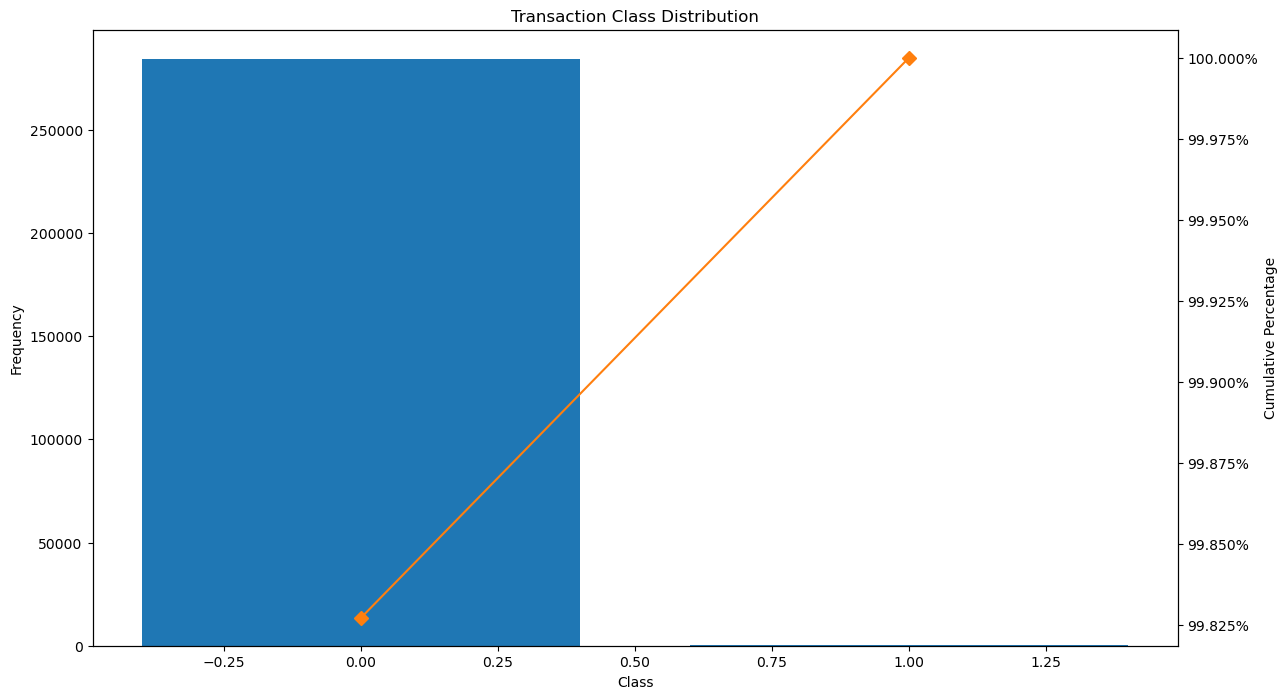

In [13]:

count_classes = pd.value_counts(dt['Class'], sort=True)
df = pd.DataFrame({'count': count_classes})
df['cumpercentage'] = df['count'].cumsum() / df['count'].sum() * 100

fig, ax = plt.subplots()
ax.bar(df.index, df['count'], color='C0')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')

ax2 = ax.twinx()
ax2.plot(df.index, df['cumpercentage'], color='C1', marker='D', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative Percentage')

plt.title('Transaction Class Distribution')


In [14]:
# Fraud and the normal are the dataset 

fraud = dt[dt['Class']==1]

normal = dt[dt['Class']==0]

In [15]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [16]:
# different amount of money used in different transaction classes
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [17]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

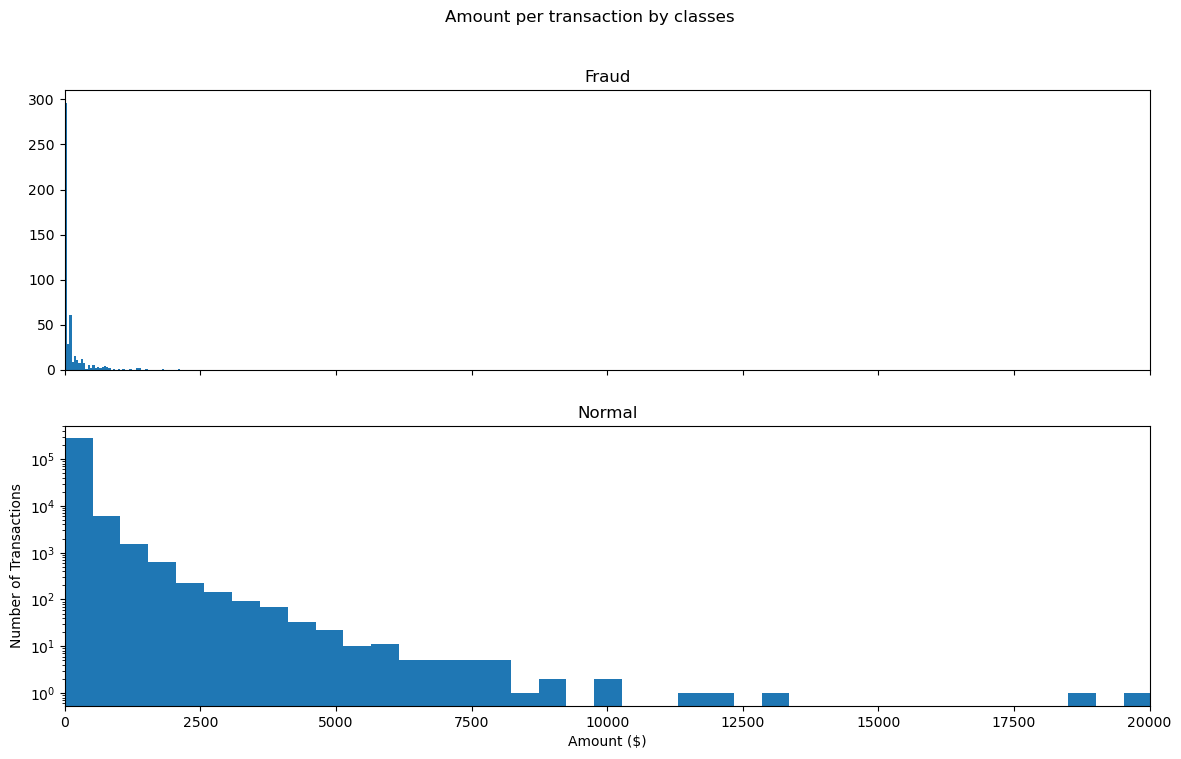

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by classes')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

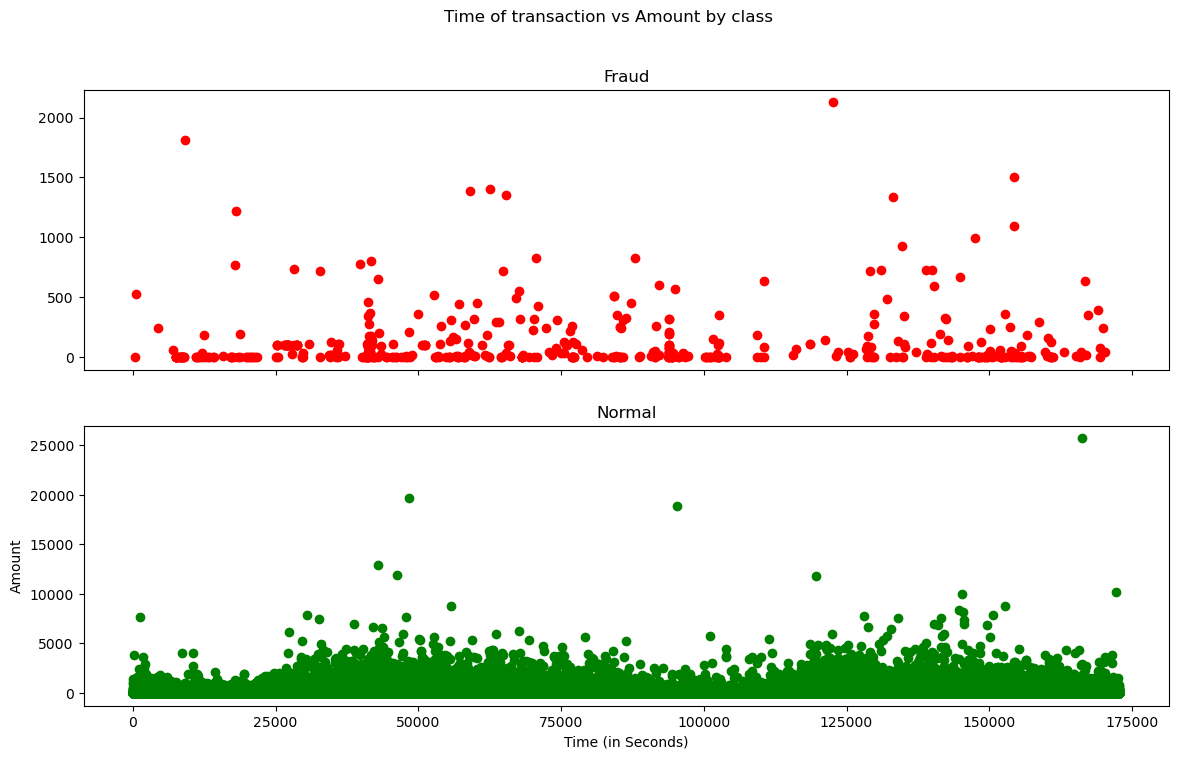

In [21]:
# We Will check fraudulent transactions occur more often during certain time frame and find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount, color='red')
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount, color='green')
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [22]:
## Take 1 percent sample of the data

dt1= dt.sample(frac = 0.1,random_state=1)

dt1.shape

(28481, 31)

In [23]:
dt.shape

(284807, 31)

In [25]:
# The number of fraud and valid transactions in the dataset

fraud = dt1[dt1['Class']==1]

Valid = dt1[dt1['Class']==0]

outlier_fraction = len(fraud)/float(len(Valid))

In [26]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


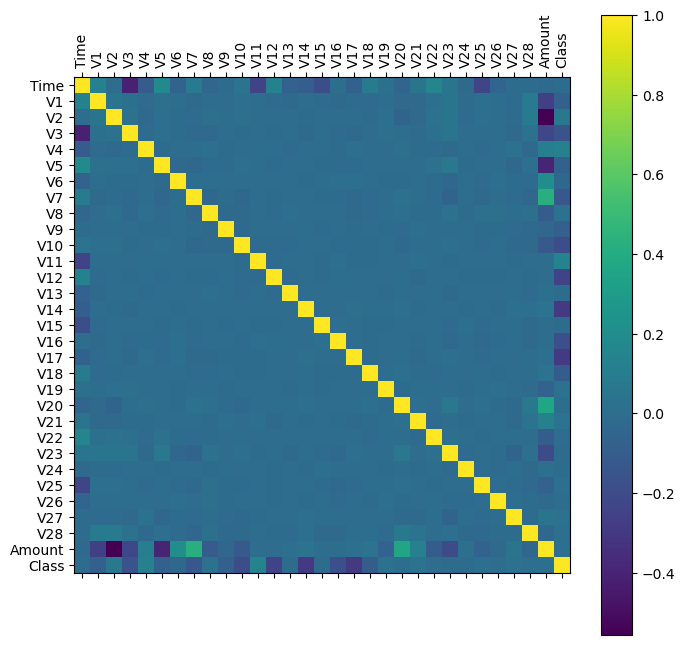

In [27]:

# Calculate the correlation matrix
corrmat = dt1.corr()

# Create the matrix plot
plt.matshow(corrmat)
plt.xticks(range(len(corrmat.columns)), corrmat.columns, rotation=90)
plt.yticks(range(len(corrmat.columns)), corrmat.columns)
plt.colorbar()
plt.show()


In [29]:
#Create independent and Dependent Features
columns = dt1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = dt1[columns]
Y = dt1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


# WE are going to use 2 Algorithm

## 1} Isolation Forest Algorithm : ##

 Unsupervised machine learning algorithm for anomaly detection
 
● Detects anomalies using binary trees.

● Linear time complexity and low memory requirement

● Anomalous data points are easier to separate from the rest of the sample

● Generates partitions on the sample by randomly selecting an attribute and a split value

● Recursive partitioning represented by a tree structure named Isolation Tree

● Popular for anomaly detection in fields such as cybersecurity, finance, and medical research



## 2} Local Outlier Factor(LOF) Algorithm

● Unsupervised anomaly detection method

● Computes the local density deviation of a given data point with respect to its neighbors

● Considers as outliers the samples that have a substantially lower density than their neighbors

● Shares some concepts with DBSCAN and OPTICS such as the concepts of "core distance" and "reachability distance"

● Locality is given by k nearest neighbors, whose distance is used to estimate the density


In [34]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [35]:
type(classifiers)

dict

In [ ]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

G:\DATASCIENCE-PROJECT\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



# OBSERVATION

● Isolation Forest detected 73 errors, Local Outlier Factor detected 97 errors, and SVM detected 8516 errors.

● Isolation Forest was 99.74% accurate, LOF was 99.65% accurate, and SVM was 70.09% accurate.

● Isolation Forest had a fraud detection rate of around 27%, LOF had a detection rate of 2%, and SVM had a detection rate of 0%.

● Overall, Isolation Forest performed the best in detecting fraud cases at around 30%.

● Accuracy can be improved by increasing sample size, using deep learning algorithms, or using more complex anomaly detection models.